In [13]:
from glotaran_tools.specification_parser import parse_yml
from glotaran_core.model import Dataset
from glotaran_models.kinetic import KineticSeperableModel
import numpy as np
from lmfit import Parameters
# Imports for plotting

import matplotlib.pyplot as plt
%matplotlib notebook

test_parameter = [201e-5, 535e-6, 800e-5, 0.1, 10]
test_amps = [1,2,3]
times = np.asarray(np.arange(-50, 1500, 1.5))

fitspec = '''
type: kinetic

parameter: {}

compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]
      
k_matrices:
  - label: "k1"
    matrix: {{
      '("s1","s1")': 1,
      '("s2","s2")': 2,
      '("s3","s3")': 3,
}}

irf:
  - label: irf1
    type: gaussian
    center: 4
    width: 5
datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    path: 'data/dataset1.ascii'
    irf: irf1

'''
model = parse_yml(fitspec.format(test_parameter))
print(model)

Modeltype: Kinetic

Parameter
---------

Index: 1 Initial Value: 0.00201 Label: None
Index: 2 Initial Value: 0.000535 Label: None
Index: 3 Initial Value: 0.008 Label: None
Index: 4 Initial Value: 0.1 Label: None
Index: 5 Initial Value: 10.0 Label: None

Megacomplexes
-------------

Label: mc1
K-Matrices: ['k1']

Datasets
--------

Dataset 'dataset1'

	Dataset Scaling: None
	Initial Concentration: None
	Megacomplexes: ['mc1']

	Irf: irf1


K-Matrices
----------

Label: k1
Matrix:
[[3 0 0]
 [0 2 0]
 [0 0 1]]


IRFs
----

Label: irf1 Type: 'Gaussian' Center: [4] Width: [5] Center Dispersion: [] Width Dispersion [] Scale: [], Nomalize: True



In [14]:
simparams = Parameters()
simparams.add("p1", 101e-5)
simparams.add("p2",606e-6)
simparams.add("p3",505e-5)
simparams.add("p4",0.3)
simparams.add("p5",21.4)
simparams.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1   0.00101     -inf      inf     None     True     None
p2  0.000606     -inf      inf     None     True     None
p3   0.00505     -inf      inf     None     True     None
p4       0.3     -inf      inf     None     True     None
p5      21.4     -inf      inf     None     True     None


In [15]:
fitmodel = KineticSeperableModel(model)
fitmodel.get_initial_fitting_parameter().pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1   0.00201     -inf      inf     None     True     None
p2  0.000535     -inf      inf     None     True     None
p3     0.008     -inf      inf     None     True     None
p4       0.1     -inf      inf     None     True     None
p5        10     -inf      inf     None     True     None


<IPython.core.display.Javascript object>


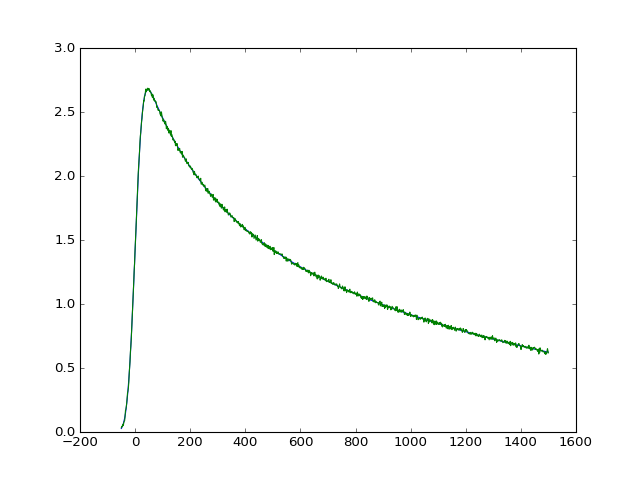

In [16]:
data = fitmodel.eval(simparams, *times, **{'dataset':'dataset1'})
noisy_data = fitmodel.eval(simparams, *times, **{'dataset':'dataset1', 'noise':True, 'noise_std_dev':0.01})

fig = plt.figure()
plt.plot(times, data[:, 0])
plt.plot(times, noisy_data[:, 0])

`xtol` termination condition is satisfied.
Function evaluations 84, initial cost 4.7711e+01, final cost 7.9844e-18, first-order optimality 1.15e-06.
Name     Value      Min      Max   Stderr     Vary     Expr
p1   0.00505     -inf      inf     None     True     None
p2  0.000606     -inf      inf     None     True     None
p3   0.00101     -inf      inf     None     True     None
p4       0.3     -inf      inf     None     True     None
p5      21.4     -inf      inf     None     True     None


<IPython.core.display.Javascript object>


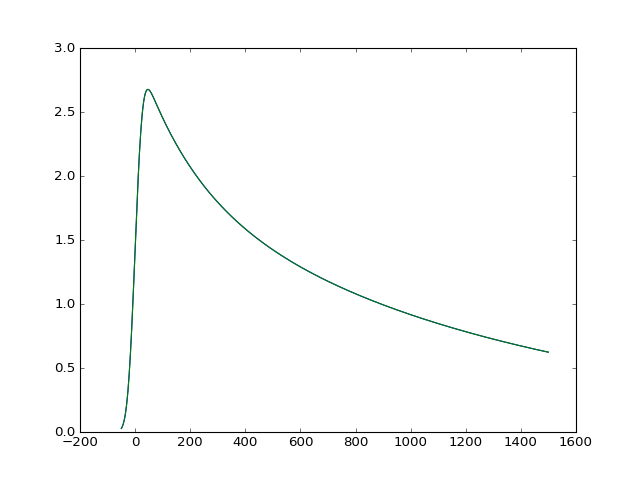

In [5]:
result = fitmodel.fit(fitmodel.get_initial_fitting_parameter(), 
                      *times, 
                      **{"data": data, 'verbose':1}
                     )
result.params.pretty_print()
fitted_data = fitmodel.eval(result.params, *times, **{'dataset':'dataset1'})
fig = plt.figure()
plt.plot(times, data[:, 0])
plt.plot(times, fitted_data[:, 0])

`ftol` termination condition is satisfied.
Function evaluations 50, initial cost 2.7938e+00, final cost 5.0149e-02, first-order optimality 8.64e-06.
Name     Value      Min      Max   Stderr     Vary     Expr
p1   0.03743     -inf      inf     None     True     None
p2   0.00477     -inf      inf     None     True     None
p3  0.0007556     -inf      inf     None     True     None
p4    0.3541     -inf      inf     None     True     None
p5     21.41     -inf      inf     None     True     None


<IPython.core.display.Javascript object>


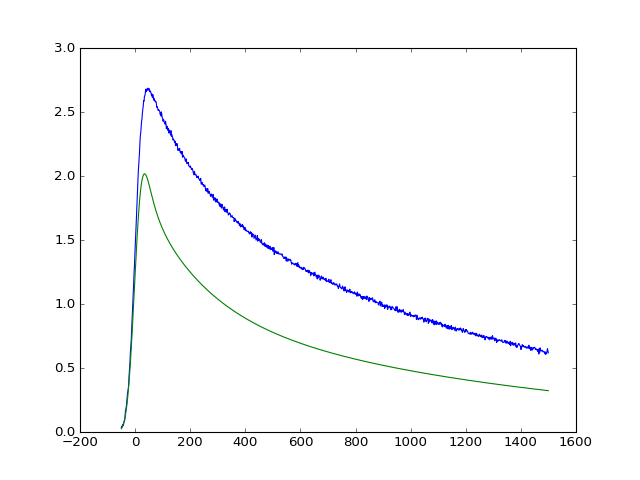

In [17]:
noise_result = fitmodel.fit(fitmodel.get_initial_fitting_parameter(), 
                      *times, 
                      **{"data": noisy_data, 'verbose':1}
                     )
noise_result.params.pretty_print()
fitted_data = fitmodel.eval(noise_result.params, *times, **{'dataset':'dataset1'})
fig = plt.figure()
plt.plot(times, noisy_data[:, 0])
plt.plot(times, fitted_data[:, 0])